### Get the data

In [2]:
from torchvision import datasets, transforms

trainset = datasets.FashionMNIST(
 root="./data",
 train=True,
 download=True,
 transform = transforms.ToTensor()
)

testset = datasets.FashionMNIST(
 root="./data",
 train=False,
 download=True,
 transform=transforms.ToTensor()
)

In [3]:
shape = trainset.data.shape

print(shape)

torch.Size([60000, 28, 28])


60,000 images, 28 x 28 pixels, and since there is no additional information, the images are grayscale

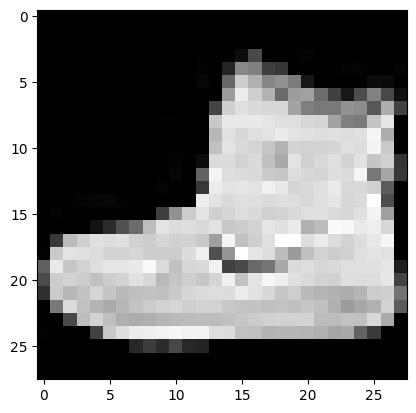

In [4]:
import matplotlib.pyplot as plt

image, label = trainset[0]

plt.imshow(image.squeeze(0).numpy(), cmap='grey')

example image

In [5]:
print("Num classes: ", len(trainset.classes))
print(trainset.classes)

Num classes:  10
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [7]:
# Get the class indexes to print images each of a kind
distinct_class_indexes = {}

for i in range(len(trainset)):
    image, label = trainset[i]

    if label not in distinct_class_indexes:
      distinct_class_indexes[label] = i
    if len(distinct_class_indexes) == len(trainset.classes):
      break

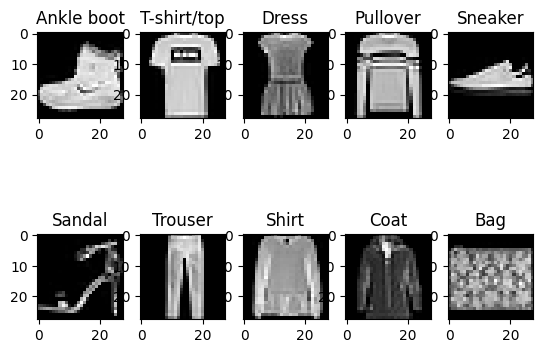

In [8]:
i = 0

for label in distinct_class_indexes:
    index = distinct_class_indexes[label]
    image, label_idx = trainset[index]
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.squeeze(0).numpy(), cmap='grey')
    plt.title(trainset.classes[label_idx])
    i += 1

### Preprocess the Data

We have 60,000 records in the training dataset.
10% for validation seems too little, 20% seems too much so I'll go with 15% of the training data.

In [11]:
import torch
import torch.utils.data as torch_data

val, train = torch_data.random_split(trainset, [int(len(trainset)*0.15), int(len(trainset)*0.85)], generator=torch.Generator().manual_seed(42))

create the data loaders for ease of working on and with the data

In [12]:
BATCH_SIZE = 64

train_loader = torch_data.DataLoader(train, BATCH_SIZE, shuffle=True)
val_loader = torch_data.DataLoader(val, BATCH_SIZE)
test_loader = torch_data.DataLoader(testset, BATCH_SIZE)

In [13]:

import torch
from torch import nn

class ParameterizedMLP(nn.Module):
  def __init__(self, input_size: int, num_classes: int, hidden_layers: list[int], use_batch_norm: bool, dropout_rate: float = 0.0) -> None:
    super().__init__()
    self.num_pixels = input_size
    self.num_classes = num_classes
    self.hidden_layers = hidden_layers # example: [512, 256]
    self.use_batch_norm = use_batch_norm
    self.layers = nn.ModuleList()
    self.current_in = self.num_pixels

    # init hidden layers
    for h_layer in hidden_layers:
      self.layers.append(nn.Linear(self.current_in, h_layer))
      if (use_batch_norm):
        self.layers.append(nn.BatchNorm1d(h_layer))
      self.layers.append(nn.ReLU())

      # if dropout
      if dropout_rate > 0:
        self.layers.append(nn.Dropout(dropout_rate))

      self.current_in = h_layer


    # init last - output - class layer
    self.layers.append(nn.Linear(self.current_in, self.num_classes))

  def forward(self, x):
    x = torch.flatten(x, 1)

    for layer in self.layers:
      x = layer(x)

    return x


### Set up a seed for output reproducibility

In [38]:
import numpy as np

def set_seed(seed=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  torch.backends.cudnn.deterministic = True

set_seed()

### Set up Logging

In [39]:
from torch.utils.tensorboard import SummaryWriter

### Model Training

##### Training Params

In [40]:
import os
import torch.optim as optim
from sklearn.metrics import f1_score

# Set training params up
criterion = nn.CrossEntropyLoss()
patience = 4 # early stopping param - how many epochs to wait for an improvement

# Calculate input size
image_shape = trainset[0][0].shape
input_size = image_shape[1] * image_shape[2]

# Set up model config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_path = 'models/best_model.pth'
os.makedirs('models', exist_ok=True)

# Set up metric tracking
train_loss_history = []
val_loss_history = []
train_f1_history = []
val_f1_history = []


##### Training loop

In [41]:
def training_loop(epochs, model, optimizer, criterion, patience, writer, early_stopping, lr_scheduler=None):
  if early_stopping:
    patience_counter = 0
    best_val_loss = float('inf')
    # Training loop
  for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
      # Move to cuda's vram, if cuda avaliable (torch handles that)
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(outputs, labels)

      loss.backward()

      optimizer.step()

      running_loss += loss.item()

    # calculate avg loss
    avg_train_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    all_val_predictions = []
    all_val_labels = []

    # eval
    model.eval()
    with torch.no_grad():
      val_running_loss = 0.0
      correct_predictions = 0
      total_predictions = 0

      for val_images, val_labels in val_loader:
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        val_outputs = model(val_images)
        _, predicted = torch.max(val_outputs, dim=1)
        correct_predictions += (predicted == val_labels).sum().item()
        total_predictions += val_labels.size(0)

        val_loss = criterion(val_outputs, val_labels)
        val_running_loss += val_loss.item()

        all_val_predictions.extend(predicted.cpu().numpy())
        all_val_labels.extend(val_labels.cpu().numpy())

      avg_val_loss = val_running_loss / len(val_loader)
      val_loss_history.append(avg_val_loss)
      val_f1 = f1_score(y_pred=all_val_predictions, y_true=all_val_labels, average='macro')
      val_f1_history.append(val_f1)

    # Step the scheduler if provided
    if lr_scheduler is not None:
        if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            lr_scheduler.step(avg_val_loss)  # Needs metric
        else:
            lr_scheduler.step()  # StepLR, etc. don't need metric
        
        # Log current learning rate to TensorBoard
        current_lr = optimizer.param_groups[0]['lr']
        writer.add_scalar('Learning_Rate', current_lr, epoch)

    # log the stats to tensorboard
    writer.add_scalar('Loss/train', avg_train_loss, epoch)
    writer.add_scalar('Loss/val', avg_val_loss, epoch)
    writer.add_scalar("F1/val", val_f1, epoch)

    # early stopping logic
    if (early_stopping):
      if (avg_val_loss < best_val_loss):
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0
        print(f"Epoch {epoch+1}/{epochs} - Model saved! Val loss improved to {best_val_loss:.4f}")
      else: 
        patience_counter += 1
        print(f"Epoch {epoch+1}/{epochs} - No improvement. Patience: {patience_counter}/{patience}")

      if (patience_counter >= patience):
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1: {val_f1:.4f}")

      


  writer.close()

#### Baseline

In [42]:
# Set model up
LR = 0.001
EPOCHS = 20
hidden_layers = [512,256]
use_batch_norm = True
model = ParameterizedMLP(input_size=input_size, num_classes=len(trainset.classes), hidden_layers=hidden_layers, use_batch_norm=use_batch_norm)
optimizer = optim.Adam(model.parameters(), lr=LR)
early_stopping = False
model.to(device)
writer = SummaryWriter(log_dir='runs/baseline')


training_loop(epochs=EPOCHS, criterion=criterion, model=model, optimizer=optimizer, patience=patience, writer=writer, early_stopping=early_stopping)

Epoch 1/20, Train Loss: 0.4458, Val Loss: 0.3799, Val F1: 0.8659
Epoch 2/20, Train Loss: 0.3385, Val Loss: 0.3309, Val F1: 0.8804
Epoch 3/20, Train Loss: 0.2978, Val Loss: 0.3168, Val F1: 0.8823
Epoch 4/20, Train Loss: 0.2734, Val Loss: 0.3277, Val F1: 0.8807
Epoch 5/20, Train Loss: 0.2519, Val Loss: 0.3346, Val F1: 0.8792
Epoch 6/20, Train Loss: 0.2318, Val Loss: 0.3634, Val F1: 0.8631
Epoch 7/20, Train Loss: 0.2178, Val Loss: 0.3218, Val F1: 0.8849
Epoch 8/20, Train Loss: 0.2026, Val Loss: 0.3222, Val F1: 0.8825
Epoch 9/20, Train Loss: 0.1903, Val Loss: 0.3147, Val F1: 0.8914
Epoch 10/20, Train Loss: 0.1752, Val Loss: 0.3465, Val F1: 0.8837
Epoch 11/20, Train Loss: 0.1631, Val Loss: 0.3038, Val F1: 0.8955
Epoch 12/20, Train Loss: 0.1501, Val Loss: 0.3386, Val F1: 0.8864
Epoch 13/20, Train Loss: 0.1420, Val Loss: 0.3134, Val F1: 0.8979
Epoch 14/20, Train Loss: 0.1316, Val Loss: 0.3374, Val F1: 0.8944
Epoch 15/20, Train Loss: 0.1244, Val Loss: 0.3397, Val F1: 0.8990
Epoch 16/20, Train 

#### Baseline + Early Stopping

In [43]:
early_stopping = True
model = ParameterizedMLP(input_size=input_size, num_classes=len(trainset.classes), hidden_layers=hidden_layers, use_batch_norm=use_batch_norm)
optimizer = optim.Adam(model.parameters(), lr=LR)
writer = SummaryWriter(log_dir='runs/baseline_early_stopping')
training_loop(epochs=EPOCHS, criterion=criterion, model=model, optimizer=optimizer, patience=patience, writer=writer, early_stopping=early_stopping)

Epoch 1/20 - Model saved! Val loss improved to 0.3746
Epoch 1/20, Train Loss: 0.4415, Val Loss: 0.3746, Val F1: 0.8538
Epoch 2/20 - Model saved! Val loss improved to 0.3526
Epoch 2/20, Train Loss: 0.3375, Val Loss: 0.3526, Val F1: 0.8724
Epoch 3/20 - Model saved! Val loss improved to 0.3390
Epoch 3/20, Train Loss: 0.2987, Val Loss: 0.3390, Val F1: 0.8715
Epoch 4/20 - Model saved! Val loss improved to 0.3188
Epoch 4/20, Train Loss: 0.2738, Val Loss: 0.3188, Val F1: 0.8860
Epoch 5/20 - Model saved! Val loss improved to 0.3040
Epoch 5/20, Train Loss: 0.2518, Val Loss: 0.3040, Val F1: 0.8876
Epoch 6/20 - No improvement. Patience: 1/4
Epoch 6/20, Train Loss: 0.2324, Val Loss: 0.3292, Val F1: 0.8841
Epoch 7/20 - No improvement. Patience: 2/4
Epoch 7/20, Train Loss: 0.2158, Val Loss: 0.3394, Val F1: 0.8821
Epoch 8/20 - No improvement. Patience: 3/4
Epoch 8/20, Train Loss: 0.2014, Val Loss: 0.3127, Val F1: 0.8912
Epoch 9/20 - No improvement. Patience: 4/4
Early stopping triggered after 9 epoch

#### More Hidden Layers

In [44]:
hidden_layers = [1024, 512, 256, 128]
model = ParameterizedMLP(input_size=input_size, num_classes=len(trainset.classes), hidden_layers=hidden_layers, use_batch_norm=use_batch_norm)
optimizer = optim.Adam(model.parameters(), lr=LR)
writer = SummaryWriter(log_dir='runs/early_stopping_more_layers')
training_loop(epochs=EPOCHS, criterion=criterion, model=model, optimizer=optimizer, patience=patience, writer=writer, early_stopping=early_stopping)

Epoch 1/20 - Model saved! Val loss improved to 0.4224
Epoch 1/20, Train Loss: 0.4763, Val Loss: 0.4224, Val F1: 0.8413
Epoch 2/20 - Model saved! Val loss improved to 0.3551
Epoch 2/20, Train Loss: 0.3617, Val Loss: 0.3551, Val F1: 0.8687
Epoch 3/20 - Model saved! Val loss improved to 0.3278
Epoch 3/20, Train Loss: 0.3205, Val Loss: 0.3278, Val F1: 0.8791
Epoch 4/20 - No improvement. Patience: 1/4
Epoch 4/20, Train Loss: 0.2964, Val Loss: 0.3491, Val F1: 0.8714
Epoch 5/20 - Model saved! Val loss improved to 0.3199
Epoch 5/20, Train Loss: 0.2757, Val Loss: 0.3199, Val F1: 0.8845
Epoch 6/20 - No improvement. Patience: 1/4
Epoch 6/20, Train Loss: 0.2562, Val Loss: 0.3289, Val F1: 0.8765
Epoch 7/20 - Model saved! Val loss improved to 0.2960
Epoch 7/20, Train Loss: 0.2380, Val Loss: 0.2960, Val F1: 0.8945
Epoch 8/20 - No improvement. Patience: 1/4
Epoch 8/20, Train Loss: 0.2254, Val Loss: 0.3005, Val F1: 0.8911
Epoch 9/20 - No improvement. Patience: 2/4
Epoch 9/20, Train Loss: 0.2107, Val Lo

#### Dropout Rate 0.5

In [45]:
hidden_layers = [512, 256] # Go back to initial hidden layers
dropout_rate = 0.5
model = ParameterizedMLP(input_size=input_size, num_classes=len(trainset.classes), hidden_layers=hidden_layers, use_batch_norm=use_batch_norm, dropout_rate=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=LR)
writer = SummaryWriter(log_dir='runs/dropout_0_5')
training_loop(epochs=EPOCHS, criterion=criterion, model=model, optimizer=optimizer, patience=patience, writer=writer, early_stopping=early_stopping)

Epoch 1/20 - Model saved! Val loss improved to 0.4169
Epoch 1/20, Train Loss: 0.5594, Val Loss: 0.4169, Val F1: 0.8405
Epoch 2/20 - Model saved! Val loss improved to 0.3586
Epoch 2/20, Train Loss: 0.4405, Val Loss: 0.3586, Val F1: 0.8668
Epoch 3/20 - Model saved! Val loss improved to 0.3585
Epoch 3/20, Train Loss: 0.4033, Val Loss: 0.3585, Val F1: 0.8681
Epoch 4/20 - Model saved! Val loss improved to 0.3385
Epoch 4/20, Train Loss: 0.3832, Val Loss: 0.3385, Val F1: 0.8731
Epoch 5/20 - Model saved! Val loss improved to 0.3249
Epoch 5/20, Train Loss: 0.3661, Val Loss: 0.3249, Val F1: 0.8802
Epoch 6/20 - No improvement. Patience: 1/4
Epoch 6/20, Train Loss: 0.3518, Val Loss: 0.3260, Val F1: 0.8785
Epoch 7/20 - Model saved! Val loss improved to 0.3104
Epoch 7/20, Train Loss: 0.3409, Val Loss: 0.3104, Val F1: 0.8811
Epoch 8/20 - No improvement. Patience: 1/4
Epoch 8/20, Train Loss: 0.3320, Val Loss: 0.3129, Val F1: 0.8803
Epoch 9/20 - No improvement. Patience: 2/4
Epoch 9/20, Train Loss: 0.3

#### Dropout Rate 0.2

In [46]:
dropout_rate = 0.2
model = ParameterizedMLP(input_size=input_size, num_classes=len(trainset.classes), hidden_layers=hidden_layers, use_batch_norm=use_batch_norm, dropout_rate=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=LR)
writer = SummaryWriter(log_dir='runs/dropout_0_2')
training_loop(epochs=EPOCHS, criterion=criterion, model=model, optimizer=optimizer, patience=patience, writer=writer, early_stopping=early_stopping)

Epoch 1/20 - Model saved! Val loss improved to 0.3886
Epoch 1/20, Train Loss: 0.4788, Val Loss: 0.3886, Val F1: 0.8576
Epoch 2/20 - Model saved! Val loss improved to 0.3570
Epoch 2/20, Train Loss: 0.3699, Val Loss: 0.3570, Val F1: 0.8656
Epoch 3/20 - No improvement. Patience: 1/4
Epoch 3/20, Train Loss: 0.3376, Val Loss: 0.3628, Val F1: 0.8636
Epoch 4/20 - Model saved! Val loss improved to 0.3349
Epoch 4/20, Train Loss: 0.3122, Val Loss: 0.3349, Val F1: 0.8781
Epoch 5/20 - Model saved! Val loss improved to 0.3125
Epoch 5/20, Train Loss: 0.2945, Val Loss: 0.3125, Val F1: 0.8833
Epoch 6/20 - No improvement. Patience: 1/4
Epoch 6/20, Train Loss: 0.2766, Val Loss: 0.3247, Val F1: 0.8814
Epoch 7/20 - Model saved! Val loss improved to 0.3061
Epoch 7/20, Train Loss: 0.2639, Val Loss: 0.3061, Val F1: 0.8844
Epoch 8/20 - Model saved! Val loss improved to 0.2981
Epoch 8/20, Train Loss: 0.2539, Val Loss: 0.2981, Val F1: 0.8921
Epoch 9/20 - No improvement. Patience: 1/4
Epoch 9/20, Train Loss: 0.2

#### LR Scheduler

In [47]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
model = ParameterizedMLP(input_size=input_size, num_classes=len(trainset.classes), hidden_layers=hidden_layers, use_batch_norm=use_batch_norm, dropout_rate=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=LR)
writer = SummaryWriter(log_dir='runs/scheduler')
training_loop(epochs=EPOCHS, criterion=criterion, model=model, optimizer=optimizer, patience=patience, writer=writer, early_stopping=early_stopping, lr_scheduler=scheduler)

c:\Users\macie\anaconda3\envs\solvroml\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1/20 - Model saved! Val loss improved to 0.3687
Epoch 1/20, Train Loss: 0.4789, Val Loss: 0.3687, Val F1: 0.8646
Epoch 2/20 - Model saved! Val loss improved to 0.3534
Epoch 2/20, Train Loss: 0.3684, Val Loss: 0.3534, Val F1: 0.8675
Epoch 3/20 - No improvement. Patience: 1/4
Epoch 3/20, Train Loss: 0.3370, Val Loss: 0.3540, Val F1: 0.8669
Epoch 4/20 - Model saved! Val loss improved to 0.3142
Epoch 4/20, Train Loss: 0.3106, Val Loss: 0.3142, Val F1: 0.8854
Epoch 5/20 - No improvement. Patience: 1/4
Epoch 5/20, Train Loss: 0.2940, Val Loss: 0.3296, Val F1: 0.8801
Epoch 6/20 - Model saved! Val loss improved to 0.3098
Epoch 6/20, Train Loss: 0.2765, Val Loss: 0.3098, Val F1: 0.8881
Epoch 7/20 - No improvement. Patience: 1/4
Epoch 7/20, Train Loss: 0.2646, Val Loss: 0.3163, Val F1: 0.8843
Epoch 8/20 - Model saved! Val loss improved to 0.3030
Epoch 8/20, Train Loss: 0.2517, Val Loss: 0.3030, Val F1: 0.8871
Epoch 9/20 - No improvement. Patience: 1/4
Epoch 9/20, Train Loss: 0.2423, Val Lo

#### SGD Optimizer

In [48]:
model = ParameterizedMLP(input_size=input_size, num_classes=len(trainset.classes), hidden_layers=hidden_layers, use_batch_norm=use_batch_norm, dropout_rate=dropout_rate)
optimizer = optim.SGD(model.parameters(), lr=LR)
writer = SummaryWriter(log_dir='runs/sgd')
training_loop(epochs=EPOCHS, criterion=criterion, model=model, optimizer=optimizer, patience=patience, writer=writer, early_stopping=early_stopping)

Epoch 1/20 - Model saved! Val loss improved to 0.8468
Epoch 1/20, Train Loss: 1.2288, Val Loss: 0.8468, Val F1: 0.7445
Epoch 2/20 - Model saved! Val loss improved to 0.6775
Epoch 2/20, Train Loss: 0.7913, Val Loss: 0.6775, Val F1: 0.7794
Epoch 3/20 - Model saved! Val loss improved to 0.5926
Epoch 3/20, Train Loss: 0.6742, Val Loss: 0.5926, Val F1: 0.8013
Epoch 4/20 - Model saved! Val loss improved to 0.5447
Epoch 4/20, Train Loss: 0.6110, Val Loss: 0.5447, Val F1: 0.8161
Epoch 5/20 - Model saved! Val loss improved to 0.5060
Epoch 5/20, Train Loss: 0.5688, Val Loss: 0.5060, Val F1: 0.8266
Epoch 6/20 - Model saved! Val loss improved to 0.4819
Epoch 6/20, Train Loss: 0.5377, Val Loss: 0.4819, Val F1: 0.8351
Epoch 7/20 - Model saved! Val loss improved to 0.4640
Epoch 7/20, Train Loss: 0.5147, Val Loss: 0.4640, Val F1: 0.8386
Epoch 8/20 - Model saved! Val loss improved to 0.4463
Epoch 8/20, Train Loss: 0.4970, Val Loss: 0.4463, Val F1: 0.8431
Epoch 9/20 - Model saved! Val loss improved to 0

#### No batch norm


In [49]:
use_batch_norm = False
model = ParameterizedMLP(input_size=input_size, num_classes=len(trainset.classes), hidden_layers=hidden_layers, use_batch_norm=use_batch_norm, dropout_rate=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=LR)
writer = SummaryWriter(log_dir='runs/no_batch_norm')
training_loop(epochs=EPOCHS, criterion=criterion, model=model, optimizer=optimizer, patience=patience, writer=writer, early_stopping=early_stopping)

Epoch 1/20 - Model saved! Val loss improved to 0.4170
Epoch 1/20, Train Loss: 0.5439, Val Loss: 0.4170, Val F1: 0.8409
Epoch 2/20 - Model saved! Val loss improved to 0.3795
Epoch 2/20, Train Loss: 0.3960, Val Loss: 0.3795, Val F1: 0.8611
Epoch 3/20 - Model saved! Val loss improved to 0.3648
Epoch 3/20, Train Loss: 0.3610, Val Loss: 0.3648, Val F1: 0.8673
Epoch 4/20 - Model saved! Val loss improved to 0.3588
Epoch 4/20, Train Loss: 0.3364, Val Loss: 0.3588, Val F1: 0.8673
Epoch 5/20 - Model saved! Val loss improved to 0.3317
Epoch 5/20, Train Loss: 0.3185, Val Loss: 0.3317, Val F1: 0.8793
Epoch 6/20 - No improvement. Patience: 1/4
Epoch 6/20, Train Loss: 0.3053, Val Loss: 0.3414, Val F1: 0.8784
Epoch 7/20 - No improvement. Patience: 2/4
Epoch 7/20, Train Loss: 0.2958, Val Loss: 0.3379, Val F1: 0.8770
Epoch 8/20 - Model saved! Val loss improved to 0.3118
Epoch 8/20, Train Loss: 0.2842, Val Loss: 0.3118, Val F1: 0.8876
Epoch 9/20 - No improvement. Patience: 1/4
Epoch 9/20, Train Loss: 0.2

### Analysis

#### Baseline vs Early Stopping:

In terms of f1, early stopping turned out worse with the params I provided (doesn't mean, and very likely so, that it's worse generally). Baseline model performed the best at epoch 16.

In terms of val loss, it was better to stop the model at epoch it was best at because later the loss started increasing fast.

![F1 Score - Baseline vs Early Stopping](analysis/baseline_early_stopping_f1.png)

![Validation Loss - Baseline vs Early Stopping](analysis/baseline_early_stopping_val_loss.png)

---

#### Model Architecture - more layers:

More layers made model worse initially but it sped up quite fast (around 5th epoch) and started to outperform the baseline model. It's performance got stopped with early stopping though.

![F1 Score - More Layers](analysis/baseline_layers_f1.png)

![Validation Loss - More Layers](analysis/baseline_layers_val_loss.png)

---

#### Dropout:

Dropout made model generalize more, rate 0.5 was the best out of the tested ones. It's performance kept stunningly persistently improving across all epochs (compared to baseline).

![F1 Score - Dropout Comparison](analysis/dropout_f1.png)

![Validation Loss - Dropout Comparison](analysis/dropout_val_loss.png)

---

#### LR Scheduler

Scheduler was better at first than the modified-up-to-dropout-0.5-model, and maybe it would've outperformed it in the final analysis but the params didn't allow for that. I think it would've in the long run. 

![F1 Score - LR Scheduler](analysis/scheduler_f1.png)

![Validation Loss - LR Scheduler](analysis/scheduler_val_loss.png)

---

#### Optimizer

Unsurprisingly, SGD turned out to be worse than Adam in both metrics measured.

![F1 Score - Optimizer Comparison](analysis/sgd_f1.png)

![Validation Loss - Optimizer Comparison](analysis/sgd_val_loss.png)

---

#### Batch Normalization

No batch norm didn't seem decisive in terms of f1 performance, compared to modified-up-to-dropout-0.5-model, and yet it got stopped with early stopping. 

Val loss was visibly higher though.

![F1 Score - Batch Normalization](analysis/no_batch_norm_f1.png)

![Validation Loss - Batch Normalization](analysis/no_batch_norm_val_loss.png)

### Results

#### lowest val loss:

modified-up-to-dropout-0.5-model

#### highest f1:

Baseline - epoch 15 (but afterwards it's performance started significantly degrading)

modified-up-to-dropout-0.5-model presented the most stably improving performance across all epochs

#### best generalization:

modified-up-to-dropout-0.5-model

### Tensor Board Visualization

![F1 Score: All Models](analysis/f1_all.png)

![Validation Loss: All Models](analysis/val_loss_all.png)